In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import SVG, HTML, display
import tifffile as tiff
import glob
import os
import pandas as pd
from datetime import datetime

## Arauca city

Sentinel-1 imagery

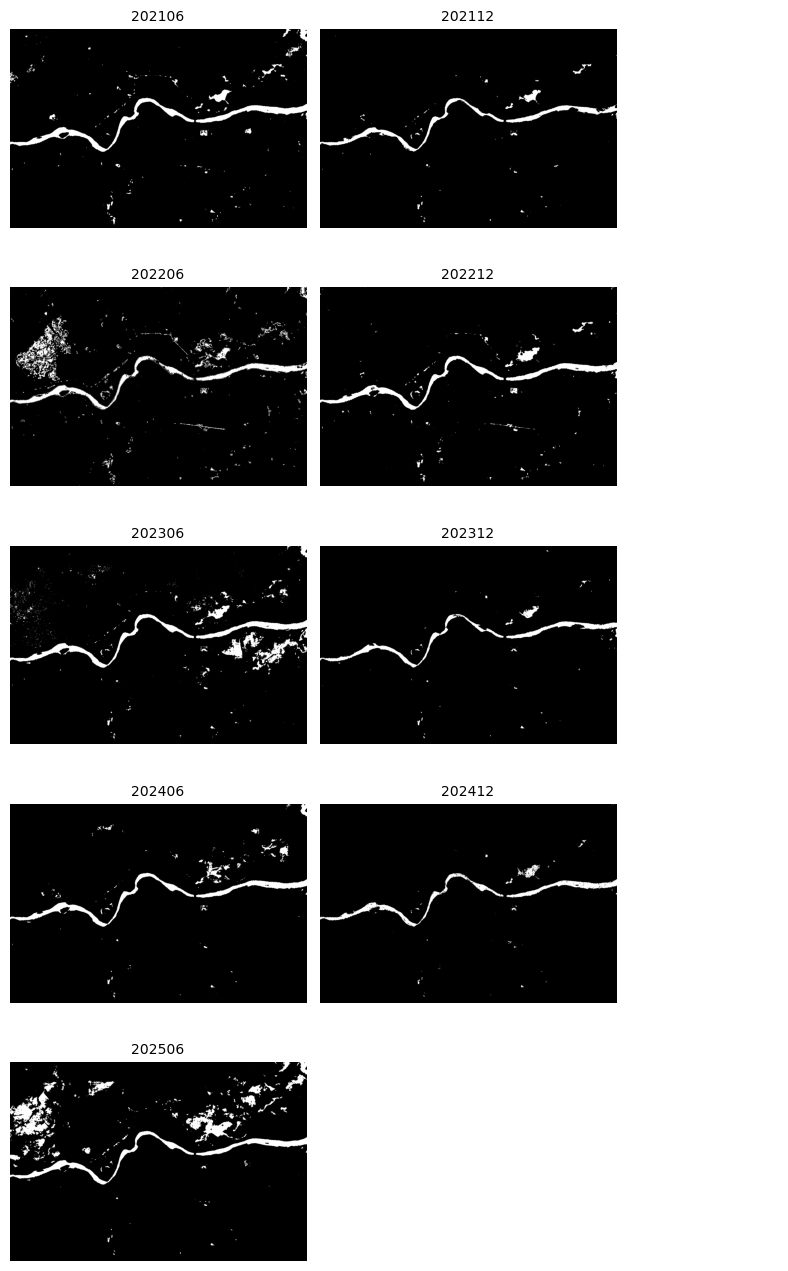

In [29]:
# Path to TIFF files
tiff_files = sorted(glob.glob("./results/aoi_arauca2/water/*.tif"))

# Create a figure with 4 rows and 3 columns
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
axes = axes.flatten()

# Loop through images and plot them
for i, file in enumerate(tiff_files):
    img = tiff.imread(file)

    # Extract the filename (without path)
    filename = os.path.basename(file)
    
    # Remove extension and take last 6 characters
    title_text = os.path.splitext(filename)[0][-6:]
    
    # Show the image
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title_text, fontsize=10)
    axes[i].axis('off')

# Hide unused axes (if fewer than 12 images)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(wspace=-0.5, hspace=0.3) 
plt.show()


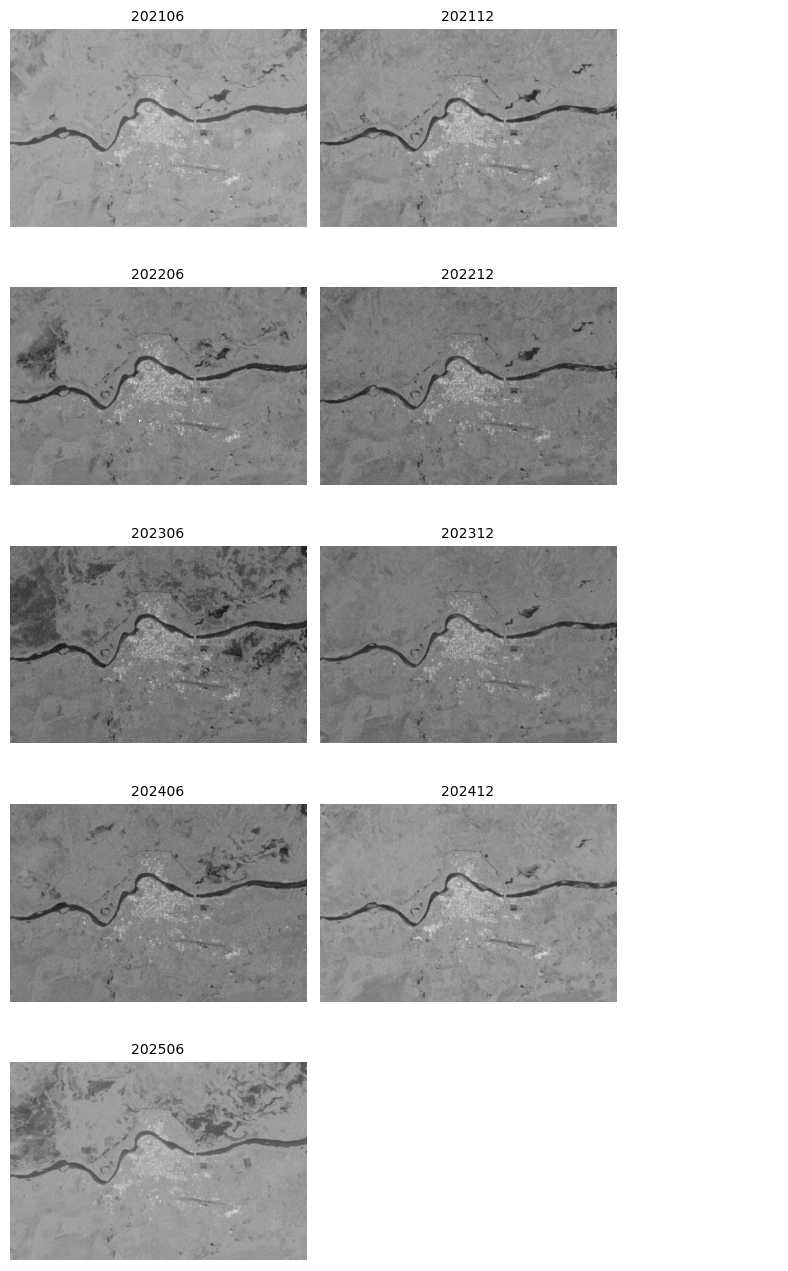

In [30]:
# Path to TIFF files
tiff_files = sorted(glob.glob("./results/aoi_arauca2/composite/*.tif"))

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
axes = axes.flatten()

# Loop through images and plot them
for i, file in enumerate(tiff_files):
    img = tiff.imread(file)

    # Extract the filename (without path)
    filename = os.path.basename(file)
    
    # Remove extension and take last 6 characters
    title_text = os.path.splitext(filename)[0][-6:]
    
    # Show the image
    axes[i].imshow(img[...,0], cmap='gray')
    axes[i].imshow(img[..., 1], cmap='gray')
    axes[i].set_title(title_text, fontsize=10)
    axes[i].axis('off')

# Hide unused axes (if fewer than 12 images)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.subplots_adjust(wspace=-0.5, hspace=0.3) 
plt.show()


Water cover area

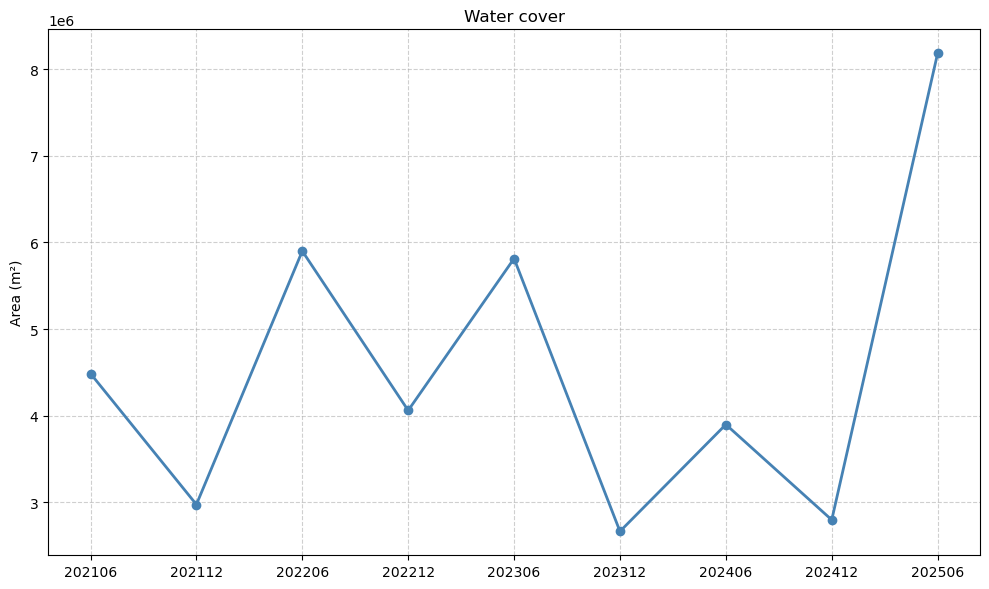

In [31]:
# Get all CSV files
csv_files = glob.glob("./results/aoi_arauca2/water-cover/*.csv")

labels = []
areas_m2 = []

for file in csv_files:
    filename = os.path.basename(file)
    label = os.path.splitext(filename)[0][:6]
    
    df = pd.read_csv(file)

    df['1'] = pd.to_numeric(df['1'].astype(str).str.replace(',', ''))
    
    area_m2= df['1'].iloc[0]
    
    labels.append(label)
    areas_m2.append(area_m2)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(labels, areas_m2, marker='o', color='steelblue', linewidth=2)
plt.title("Water cover")
plt.ylabel("Area (m²)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Precipitation

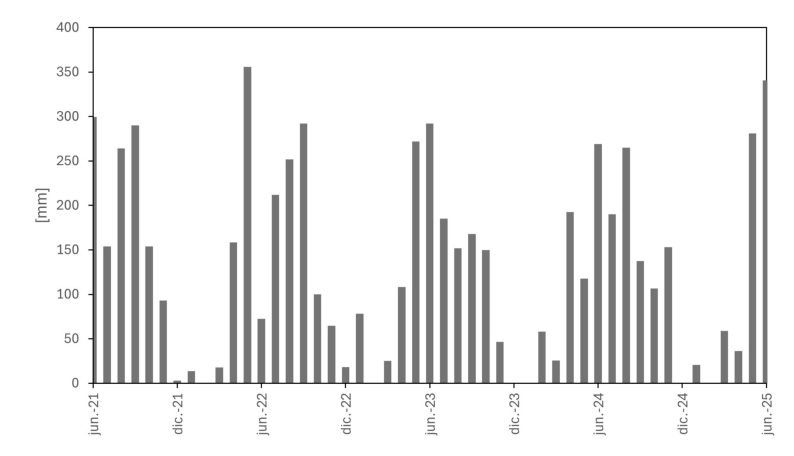

In [32]:
img = mpimg.imread('./data/arauca/precip_ara/2021-2025.jpg')
# Display smaller
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()